# Config and Imports

In [1]:
import os
os.chdir('../../')
prj_path = "./data/IGs/"
print(os.getcwd())

c:\Users\andri\Progetti\igraph_transformer


In [2]:
import random

import torch
import pickle
import torch.utils.data
import time
import os
import numpy as np

import csv

import dgl

from scipy import sparse as sp
import networkx as nx
import hashlib

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from torch.utils.data import SubsetRandomSampler, DataLoader
from collections import defaultdict
from data.IGs_V2 import IGsDatasetDGL

Using backend: pytorch


# Prepare dataset

txt --> train/test/val PKL: NO DGL

In [3]:
data_list = []
dataset = []

#data_path = prj_path + 'ig_subgraphs.txt'
with open(prj_path + 'ig_subgraphs.txt', 'r') as file:
    for line in file:
        line = line.strip()  # Remove whitespace and newline characters
        values = line.split(']')  # Split the line based on the ']' character
        nums = values[0].strip('[, ')  # Extract the numbers inside the square brackets
        nums = [int(num) for num in nums.split(',')]  # Convert the numbers into a list of integers
        num_after_bracket = int(values[1].strip())  # Extract the number after the square bracket
        data_list.append([nums, num_after_bracket])

random.shuffle(data_list)

G = nx.Graph()

for data in data_list:
  nodes, label = data[:2]
  edges = [(nodes[i], nodes[i+1]) for i in range(len(nodes)-1)]

  G.clear()  # Svuota il grafo precedente
  G.add_nodes_from(nodes)
  G.add_edges_from(edges)

  obj = (G.copy(), int(label))
  dataset.append(obj)
  
with open(prj_path + 'igraph-GTN.pkl', 'wb') as f:
  pickle.dump(dataset, f)

In [4]:
len(dataset)

53447

### Split and Dump train,val,test pkl

In [6]:
from torch.utils.data import WeightedRandomSampler
from torch.utils.data import Subset
#-------------------------------TRAIN-----------------------------
train_p = 0.7  # Train set percentage
num_samples = len(dataset)
train_samples = int(train_p * num_samples)

targets = [data[1] for data in dataset]

# Calculate the frequency of each class and get the weights for each class
class_counts = torch.bincount(torch.tensor(targets))
class_weights = torch.true_divide(1.0, class_counts)

# Normalize the class weights
# class_weights /= torch.max(class_weights)

# Create a tensor of class labels
targets = torch.tensor(torch.tensor(targets))

# WeightedRandomSampler for weight based sampling with replacement
sampler = WeightedRandomSampler(class_weights[targets], train_samples, replacement=False)

train_indices = list(sampler)

# Use the sampler to sample the dataset for the trainset
train = torch.utils.data.Subset(dataset, train_indices)

#-------------------------------TEST/VAL-----------------------------
# Create a subset of the dataset excluding the train indices
remaining_indices = list(set(range(len(dataset))) - set(train_indices))

test_p = 0.6 # % of the remaining samples (note! replacement was used)
test_size = int(test_p*len(remaining_indices))
test_indices = random.sample(remaining_indices, test_size)

# Create the test set with the sampled indices
test = Subset(dataset, test_indices)

# Create a subset of the dataset excluding the train and test indices
val_indices = list(set(range(len(dataset))) - set(train_indices) - set(test_indices))
# val_indices = random.sample(val_indices, test_size)


# Create the test set with the sampled indices
val = Subset(dataset, val_indices)

print(len(train), len(test), len(val))

37412 9621 6414


c:\Users\andri\miniconda3\envs\graph_transformer\lib\site-packages\ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Total samples in dataset: 37412
class 5: 3040 samples
class 13: 2685 samples
class 7: 3895 samples
class 15: 137 samples
class 6: 4160 samples
class 2: 3160 samples
class 3: 2530 samples
class 9: 2756 samples
class 4: 2502 samples
class 14: 1914 samples
class 11: 3311 samples
class 8: 1322 samples
class 12: 1668 samples
class 10: 4332 samples


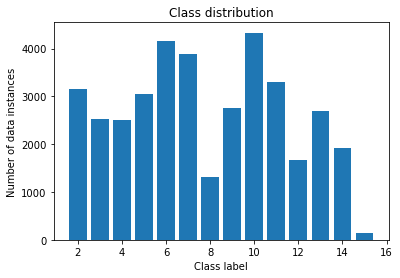

In [7]:
import matplotlib.pyplot as plt
from collections import defaultdict

plt_ds = train

print(f"Total samples in dataset: {len(plt_ds)}")
# Count number of data instances in each class for test set
class_counts = defaultdict(int)
for i, data in enumerate(plt_ds):
    label = data[1]
    class_counts[label] += 1

for key, value in class_counts.items():
    print(f"class {key}: {value} samples")

# Plot bar chart of class distribution for test set
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Class label')
plt.ylabel('Number of data instances')
plt.title(f'Class distribution')
plt.show()


In [8]:
#train, test_val_data = train_test_split(dataset, test_size=0.3, random_state=42)
#test, val = train_test_split(test_val_data, test_size=0.7, random_state=42)

start = time.time()
with open(prj_path + 'igraph-GTN-v2-train.pkl','wb') as f:
        pickle.dump(train, f)
with open(prj_path + 'igraph-GTN-v2-test.pkl','wb') as f:
        pickle.dump(test, f)
with open(prj_path + 'igraph-GTN-v2-val.pkl','wb') as f:
        pickle.dump(val, f)

print('Time (sec):',time.time() - start)

Time (sec): 1.6746444702148438


# Load Dataset

In [9]:
if not os.path.isfile(prj_path + 'igraph-DatasetDGL-v2.pkl'):
  # file presente --> pkl load
  # with open(prj_path + 'igraph-DatasetDGL.pkl', "rb") as f:
  #   f = pickle.load(f)
  #   datasetDGL = f
  datasetDGL = IGsDataset()
else:
  # dataset non presente -> generazione
  datasetDGL = IGsDatasetDGL()

  start = time.time()
  with open(prj_path + 'igraph-DatasetDGL-v2.pkl', 'wb') as f:
          #pickle.dump([datasetDGL.train,datasetDGL.val,datasetDGL.test], f)
          pickle.dump(datasetDGL, f)
  print('Time (sec):',time.time() - start)

[I] Loading data ...
preparing 37412 graphs for the TRAIN set...


c:\Users\andri\miniconda3\envs\graph_transformer\lib\site-packages\dgl\base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)


preparing 6414 graphs for the VAL set...
preparing 9621 graphs for the TEST set...
[I] Finished loading.
Time taken: 389.9757s
Time (sec): 21.942267179489136


In [38]:
datasetDGL.train[1][0]

Graph(num_nodes=14, num_edges=26,
      ndata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)}
      edata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)})

In [29]:
graph, label = datasetDGL.train[0:100]
label

[tensor(10),
 tensor(14),
 tensor(10),
 tensor(6),
 tensor(4),
 tensor(2),
 tensor(10),
 tensor(7),
 tensor(5),
 tensor(4),
 tensor(13),
 tensor(8),
 tensor(8),
 tensor(3),
 tensor(15),
 tensor(2),
 tensor(5),
 tensor(13),
 tensor(6),
 tensor(2),
 tensor(2),
 tensor(5),
 tensor(15),
 tensor(6),
 tensor(12),
 tensor(7),
 tensor(9),
 tensor(11),
 tensor(6),
 tensor(6),
 tensor(9),
 tensor(8),
 tensor(4),
 tensor(13),
 tensor(3),
 tensor(9),
 tensor(11),
 tensor(13),
 tensor(8),
 tensor(13),
 tensor(7),
 tensor(4),
 tensor(13),
 tensor(7),
 tensor(15),
 tensor(11),
 tensor(9),
 tensor(13),
 tensor(7),
 tensor(2),
 tensor(9),
 tensor(10),
 tensor(11),
 tensor(3),
 tensor(3),
 tensor(8),
 tensor(9),
 tensor(5),
 tensor(3),
 tensor(2),
 tensor(3),
 tensor(4),
 tensor(14),
 tensor(10),
 tensor(7),
 tensor(14),
 tensor(9),
 tensor(9),
 tensor(3),
 tensor(3),
 tensor(15),
 tensor(4),
 tensor(12),
 tensor(5),
 tensor(9),
 tensor(6),
 tensor(12),
 tensor(15),
 tensor(12),
 tensor(15),
 tensor(11)

### Explore dataset

In [9]:
print(len(datasetDGL.train))
print(len(datasetDGL.val))
print(len(datasetDGL.test))

print(datasetDGL.train[0])
print(datasetDGL.val[0])
print(datasetDGL.test[0])

50595
6515
15175
(Graph(num_nodes=17, num_edges=12,
      ndata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)}
      edata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)}), tensor(10))
(Graph(num_nodes=14, num_edges=11,
      ndata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)}
      edata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)}), tensor(10))
(Graph(num_nodes=10, num_edges=9,
      ndata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)}
      edata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)}), tensor(10))


In [6]:
import matplotlib.pyplot as plt
from collections import defaultdict

# Count number of data instances in each class for test set
class_counts = defaultdict(int)
for i, data in enumerate(test):
    label = data['target']
    class_counts[label.item()] += 1

# Plot bar chart of class distribution for test set
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Class label')
plt.ylabel('Number of data instances')
plt.title('Class distribution for test set')
plt.show()


NameError: name 'test' is not defined

In [7]:
# Create set of unique classes in train set
unique_classes = set()
for data in train:
    label = data['target']
    unique_classes.add(label.item())

# Count number of unique classes
num_classes = len(unique_classes)
print("Number of unique classes in train set: ", num_classes)
print(unique_classes)

NameError: name 'train' is not defined

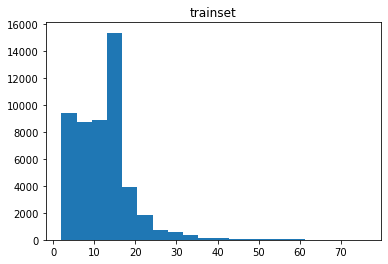

min/max : 2 76


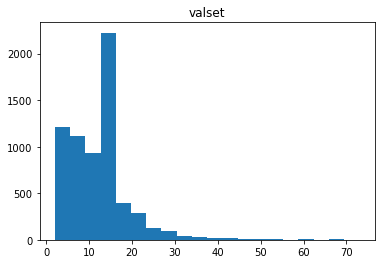

min/max : 2 73


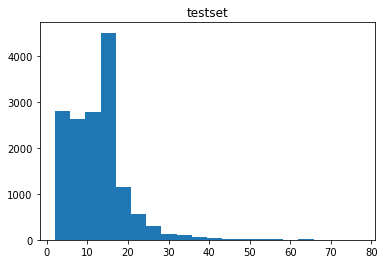

min/max : 2 77


In [8]:
def plot_histo_graphs(dataset, title):
    # histogram of graph sizes
    graph_sizes = []
    for graph in dataset:
        graph_sizes.append(graph[0].number_of_nodes())
    plt.figure(1)
    plt.hist(graph_sizes, bins=20)
    plt.title(title)
    plt.show()
    graph_sizes = torch.Tensor(graph_sizes)
    print('min/max :',graph_sizes.min().long().item(),graph_sizes.max().long().item())

plot_histo_graphs(datasetDGL.train,'trainset')
plot_histo_graphs(datasetDGL.val,'valset')
plot_histo_graphs(datasetDGL.test,'testset')

# Test

In [50]:
train[0]

{'num_node': 14,
 'node_type': tensor([0, 1, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6], dtype=torch.int8),
 'adj': tensor([[0, 1, 0, 0, 0, 0, 0],
         [0, 0, 1, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 1],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 1]], dtype=torch.int8),
 'target': tensor(6)}

In [68]:
datasetDGL.train[0][1].item()


6